In [1]:
%pip install -q yellowbrick

In [2]:
import pandas as pd
import numpy as np

import re, os, math, datetime

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [3]:
df = pd.read_excel("/content/Dummy Akte Pendirian.xlsx")
df.head()

,NPWP,Nama,Akte Pendirian,Tanggal
0,01.001.606.1-093.000,CV. PEGADAIAN,2158/UP/PT/2001,15/05/2001
1,02.995.457.5-005.000,CV. SAE MITRA SEJATI,9371/UP/PT/2018,2018-03-11 00:00:00
2,09.254.294.3-407.000,PT. PERTAMINA (PERSERO),4029/UP/PT/2011,28/09/2011
3,66.631.069.3-655.000,PT. Bank Negara Indonesia Tbk (Persero),5820/UP/PT/2012,2012-12-07 00:00:00
4,09.441.885.2-001.000,PT. Adi Surya Tbk (Persero),4362/UP/PT/2004,2004-06-02 00:00:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   NPWP            97 non-null     object
 1   Nama            97 non-null     object
 2   Akte Pendirian  97 non-null     object
 3   Tanggal         97 non-null     object
dtypes: object(4)
memory usage: 3.2+ KB


In [5]:
df.shape

(97, 4)

In [6]:
df['Nama'] = df['Nama'].apply(lambda x:x.lower().strip())
df['NPWP'] = df['NPWP'].apply(lambda x:x.lower().strip())
df['Akte Pendirian'] = df['Akte Pendirian'].astype('str').apply(lambda x:x.lower().strip())

In [7]:
def normalization_text(text):
  text = text.lower().strip()
  text = re.sub('[^A-Za-z0-9\s]', '', text)
  text = " ".join([i.strip() for i in text.split() if i])
  return text

def normalization_npwp(text):
  text = text.strip()
  text = re.sub('[^0-9]', '', text)
  text = text.strip()
  return text

def normalization_nap(text):
  text = text.strip()
  text = re.findall("[0-9]{4}", text)
  return "".join(text)

def normalization_date(date):
  date = str(date)
  if re.search("[/]", date):
    date = date.split("/")
    date = datetime.datetime(int(date[2]), int(date[1]), int(date[0]))
  
  date = str(date).split(" ")[0].split("-")
  date = "".join(date)
  return date

In [8]:
df['NPWP'] = df['NPWP'].apply(normalization_npwp).astype('int64')
df['Nama'] = df['Nama'].apply(normalization_text)
df['Akte Pendirian'] = df['Akte Pendirian'].apply(normalization_nap).astype('int64')
df['Tanggal'] = df['Tanggal'].apply(normalization_date).astype('int64')

In [9]:
df.head()

,NPWP,Nama,Akte Pendirian,Tanggal
0,10016061093000,cv pegadaian,21582001,20010515
1,29954575005000,cv sae mitra sejati,93712018,20180311
2,92542943407000,pt pertamina persero,40292011,20110928
3,666310693655000,pt bank negara indonesia tbk persero,58202012,20121207
4,94418852001000,pt adi surya tbk persero,43622004,20040602


In [10]:
nn = NearestNeighbors(n_neighbors=5, radius=0.4)
nn.fit(df[['NPWP','Akte Pendirian','Tanggal']])

NearestNeighbors(radius=0.4)

In [11]:
neighbors = nn.kneighbors([[10016061093000, 21582001, 20010515]], return_distance=True)
neighbors

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


(array([[0.00000000e+00, 1.00000001e+04, 2.32961703e+12, 2.32961703e+12,
         2.32961781e+12]]),
 array([[ 0, 31,  6, 37, 28]]))

In [12]:
df[df.index.isin(neighbors[1].reshape(-1))]

,NPWP,Nama,Akte Pendirian,Tanggal
0,10016061093000,cv pegadaian,21582001,20010515
6,12345678123000,pt sejati tbk persero,96152008,20081221
28,12345678901234,pt inti makmur,20152003,20030630
31,10016061093001,pt adhi karya,21582002,20020515
37,12345678123001,cv richnot,96152009,20091221


In [13]:
def calculate_nearest_neighbor(data, data2):
  score = euclidean_distances(data, data2)
  return score

In [14]:
score = calculate_nearest_neighbor(
    [df[['NPWP','Akte Pendirian','Tanggal']].values[0]], 
    df[['NPWP','Akte Pendirian','Tanggal']].values
)

In [15]:
df['distance'] = score.reshape(-1)
df.head()

,NPWP,Nama,Akte Pendirian,Tanggal,distance
0,10016061093000,cv pegadaian,21582001,20010515,0.000000e+00
1,29954575005000,cv sae mitra sejati,93712018,20180311,1.993851e+13
2,92542943407000,pt pertamina persero,40292011,20110928,8.252688e+13
3,666310693655000,pt bank negara indonesia tbk persero,58202012,20121207,6.562946e+14
4,94418852001000,pt adi surya tbk persero,43622004,20040602,8.440279e+13


In [16]:
df.sort_values(by=['distance'], ascending=True)

,NPWP,Nama,Akte Pendirian,Tanggal,distance
0,10016061093000,cv pegadaian,21582001,20010515,0.000000e+00
31,10016061093001,pt adhi karya,21582002,20020515,1.310720e+05
6,12345678123000,pt sejati tbk persero,96152008,20081221,2.329617e+12
37,12345678123001,cv richnot,96152009,20091221,2.329617e+12
28,12345678901234,pt inti makmur,20152003,20030630,2.329618e+12
...,...,...,...,...,...
11,881916756937000,cv indah jaya baru,59382019,20191022,8.719007e+14
42,881916756937001,cv kilnin,21582002,20021022,8.719007e+14
79,887823597778000,stellarenterprises,1234,19980314,8.778075e+14
86,943475534267000,alphaomega,1901,19990831,9.334595e+14


# Text

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tf_idf = TfidfVectorizer(
    lowercase=True, 
    ngram_range=(1, 1)
)

nama = tf_idf.fit_transform(df['Nama'])


pickle.dump(tf_idf, open("tfidf.pkl", "wb"))

company = "makmur"

score_similarity = cosine_similarity(
    tf_idf.transform(np.array([company])).toarray() ,
    nama.toarray()
).reshape(-1)

In [18]:
df['name_similarity'] = 1 - score_similarity
df.head()

,NPWP,Nama,Akte Pendirian,Tanggal,distance,name_similarity
0,10016061093000,cv pegadaian,21582001,20010515,0.000000e+00,1.0
1,29954575005000,cv sae mitra sejati,93712018,20180311,1.993851e+13,1.0
2,92542943407000,pt pertamina persero,40292011,20110928,8.252688e+13,1.0
3,666310693655000,pt bank negara indonesia tbk persero,58202012,20121207,6.562946e+14,1.0
4,94418852001000,pt adi surya tbk persero,43622004,20040602,8.440279e+13,1.0


In [19]:
df.sort_values(by=['name_similarity'], ascending=False)

,NPWP,Nama,Akte Pendirian,Tanggal,distance,name_similarity
0,10016061093000,cv pegadaian,21582001,20010515,0.000000e+00,1.000000
74,737639648574000,unityworks,4567,20070630,7.276236e+14,1.000000
72,118340015293000,brightmind,3456,20011128,1.083240e+14,1.000000
71,776630444341000,globalvision,1234,20030515,7.666144e+14,1.000000
70,97311967649000,globaltech,2567,20191202,8.729591e+13,1.000000
...,...,...,...,...,...,...
45,155042581104001,pt setya makmur,58202013,20130614,1.450265e+14,0.498701
18,641328549751000,pt abadi sentosa makmur,87312015,20150729,6.313125e+14,0.480330
29,123456789012340,cv berkah makmur,12012019,20190108,1.134407e+14,0.455110
55,78901234567890,sejahtera makmur jaya cv,2007,20070828,6.888517e+13,0.452723


In [20]:
df['penalty_score'] = (df['distance'] * 0.2) + (df['name_similarity'] * 0.8)

In [21]:
df.sort_values(by=['penalty_score'], ascending=True)

,NPWP,Nama,Akte Pendirian,Tanggal,distance,name_similarity,penalty_score
0,10016061093000,cv pegadaian,21582001,20010515,0.000000e+00,1.000000,8.000000e-01
31,10016061093001,pt adhi karya,21582002,20020515,1.310720e+05,1.000000,2.621520e+04
6,12345678123000,pt sejati tbk persero,96152008,20081221,2.329617e+12,1.000000,4.659234e+11
37,12345678123001,cv richnot,96152009,20091221,2.329617e+12,1.000000,4.659234e+11
28,12345678901234,pt inti makmur,20152003,20030630,2.329618e+12,0.498701,4.659236e+11
...,...,...,...,...,...,...,...
11,881916756937000,cv indah jaya baru,59382019,20191022,8.719007e+14,1.000000,1.743801e+14
42,881916756937001,cv kilnin,21582002,20021022,8.719007e+14,1.000000,1.743801e+14
79,887823597778000,stellarenterprises,1234,19980314,8.778075e+14,1.000000,1.755615e+14
86,943475534267000,alphaomega,1901,19990831,9.334595e+14,1.000000,1.866919e+14


# Segmentasi - KMeans

In [22]:
df[['NPWP','Akte Pendirian','Tanggal']].head()

,NPWP,Akte Pendirian,Tanggal
0,10016061093000,21582001,20010515
1,29954575005000,93712018,20180311
2,92542943407000,40292011,20110928
3,666310693655000,58202012,20121207
4,94418852001000,43622004,20040602


In [23]:
from sklearn.cluster import KMeans, DBSCAN


kmean = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(df[['NPWP','Akte Pendirian','Tanggal']])
kmean.predict([['10016061093000', '21582001', '20010515']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([3], dtype=int32)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

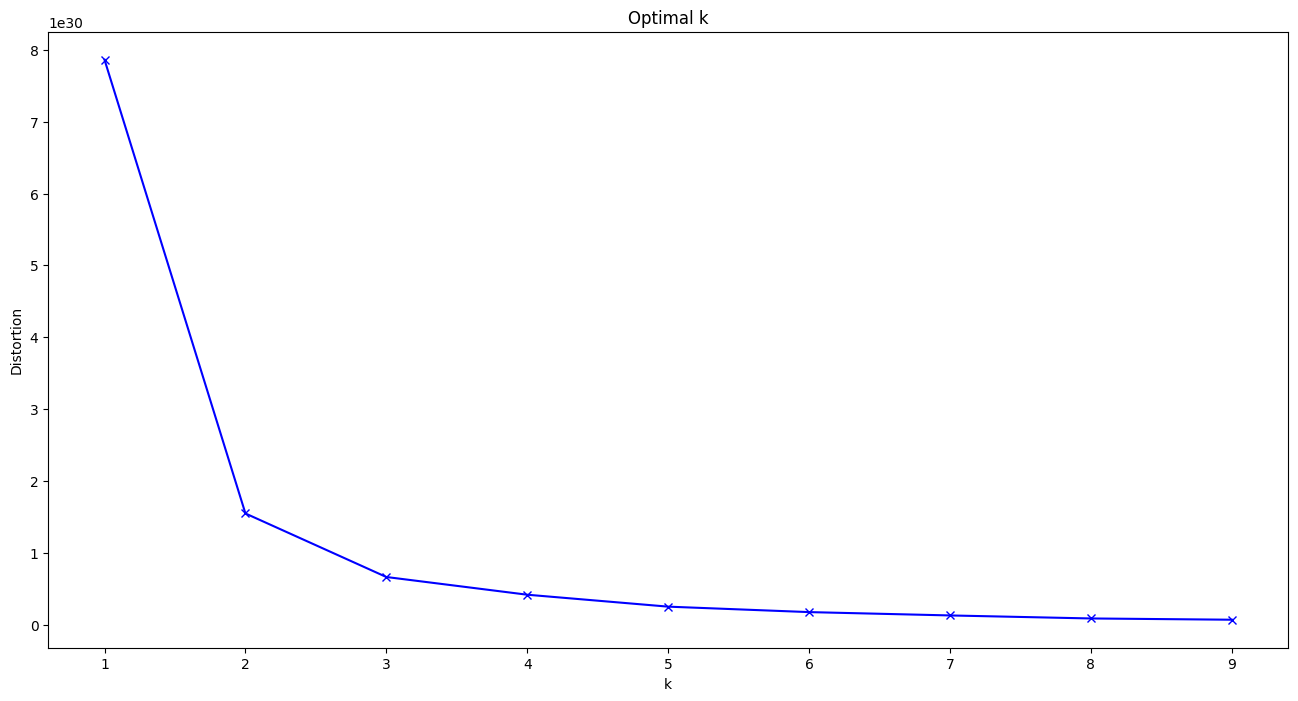

In [24]:
distortions = []
K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k)
    kmean.fit(df[['NPWP','Akte Pendirian','Tanggal']])
    distortions.append(kmean.inertia_)


plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Optimal k')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

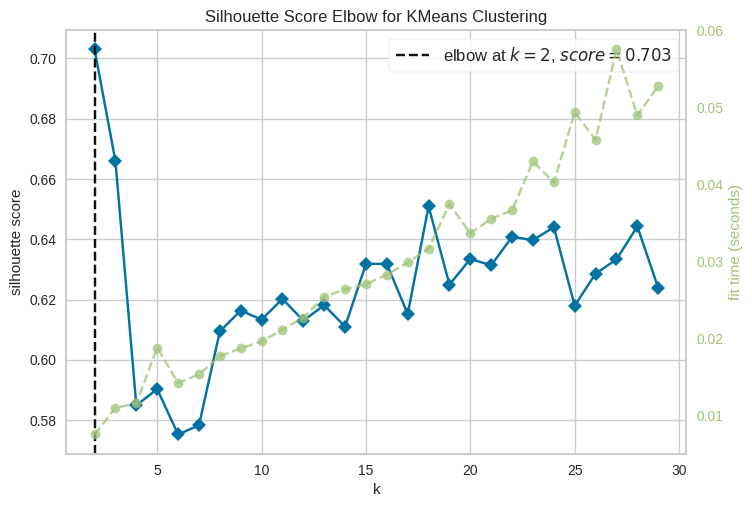

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [25]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,30), metric='silhouette', timings= True)
visualizer.fit(df[['NPWP','Akte Pendirian','Tanggal']])        
visualizer.show()   

In [26]:
data = df[['NPWP','Akte Pendirian','Tanggal']]
data

,NPWP,Akte Pendirian,Tanggal
0,10016061093000,21582001,20010515
1,29954575005000,93712018,20180311
2,92542943407000,40292011,20110928
3,666310693655000,58202012,20121207
4,94418852001000,43622004,20040602
...,...,...,...
92,148893373426000,2678,20141216
93,315288473810000,2567,20010518
94,522667581422000,2890,20130321
95,769796439714000,2789,20020607


In [27]:
kmean = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(df[['NPWP','Akte Pendirian','Tanggal']])
prediction = kmean.predict(df[['NPWP','Akte Pendirian','Tanggal']])

In [28]:
from sklearn.metrics import silhouette_score

score = silhouette_score(df[['NPWP','Akte Pendirian','Tanggal']], prediction, metric="euclidean")
print(score)

0.6658703406964739


In [29]:
df.shape

(97, 7)

In [30]:
# from sklearn.cluster import KMeans
# from sklearn.datasets import make_blobs
# from sklearn.metrics import pairwise_distances
# import numpy as np
# import matplotlib.pyplot as plt

# def compute_gap(data, max_k):
#     gaps = np.zeros((max_k,))
#     stds = np.zeros((max_k,))
#     Wks = np.zeros((max_k,))

#     B = max_k 
#     for k in range(1, max_k+1):
#         km = KMeans(n_clusters=k).fit(data)

#         Wks[k-1] = km.inertia_

#         bw_ref = np.zeros((B,))
#         for i in range(B):

#             Xb = np.random.rand(*data.shape)
  
#             kmb = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(Xb)

#             bw_ref[i] = kmb.inertia_

#         gaps[k-1] = np.mean(np.log(bw_ref)) - np.log(Wks[k-1])
#         stds[k-1] = np.sqrt(1 + 1/B) * np.std(np.log(bw_ref))
#     return gaps, stds, Wks


# gaps, stds, Wks = compute_gap(df[['NPWP','Akte Pendirian','Tanggal']], max_k=97)


# fig, ax = plt.subplots()
# ax.errorbar(np.arange(1, 98), gaps, yerr=stds, fmt='o-', capsize=5)
# ax.set_xlabel('Number of clusters')
# ax.set_ylabel('Gap statistic')
# plt.show()


In [31]:
# gaps_list = gaps.tolist()
# gaps_list.index(max(gaps))+1

In [32]:
pickle.dump(kmean, open("kmean_3_clusters.pkl", "wb"))

# Distance Per Columns

In [33]:
tgl_similarity = calculate_nearest_neighbor([[df['Tanggal'].values[0]]], df[['Tanggal']].values)
npw_similarity = calculate_nearest_neighbor([[df['NPWP'].values[0]]], df[['NPWP']].values)
nam_similarity = calculate_nearest_neighbor(tf_idf.transform(np.array([df['Nama'].values[0]])).toarray(), nama.toarray())
ap_similarity = calculate_nearest_neighbor([[df['Akte Pendirian'].values[0]]], df[['Akte Pendirian']].values)

In [34]:
df = df[['NPWP','Nama','Akte Pendirian','Tanggal']]
df['tgl_sim'] = tgl_similarity.reshape(-1)
df['npw_sim'] = npw_similarity.reshape(-1)
df['nam_sim'] = nam_similarity.reshape(-1)
df['ap_sim'] = ap_similarity.reshape(-1)

<ipython-input-34-ede8889d0ff5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tgl_sim'] = tgl_similarity.reshape(-1)
<ipython-input-34-ede8889d0ff5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['npw_sim'] = npw_similarity.reshape(-1)


In [35]:
df.head()

,NPWP,Nama,Akte Pendirian,Tanggal,tgl_sim,npw_sim,nam_sim,ap_sim
0,10016061093000,cv pegadaian,21582001,20010515,0.0,0.000000e+00,0.000000,0.0
1,29954575005000,cv sae mitra sejati,93712018,20180311,169796.0,1.993851e+13,1.318225,72130017.0
2,92542943407000,pt pertamina persero,40292011,20110928,100413.0,8.252688e+13,1.414214,18710010.0
3,666310693655000,pt bank negara indonesia tbk persero,58202012,20121207,110692.0,6.562946e+14,1.414214,36620011.0
4,94418852001000,pt adi surya tbk persero,43622004,20040602,30087.0,8.440279e+13,1.414214,22040003.0


In [36]:
df['penalty'] = (df['tgl_sim'] * 0.2) + (df['npw_sim'] * 0.3) + (df['nam_sim'] * 0.4) + (df['ap_sim'] * 0.1)

In [37]:
df.sort_values(by=['penalty'], ascending=True)

,NPWP,Nama,Akte Pendirian,Tanggal,tgl_sim,npw_sim,nam_sim,ap_sim,penalty
0,10016061093000,cv pegadaian,21582001,20010515,0.0,0.000000e+00,0.000000,0.0,0.000000e+00
31,10016061093001,pt adhi karya,21582002,20020515,10000.0,0.000000e+00,1.414214,1.0,2.000666e+03
28,12345678901234,pt inti makmur,20152003,20030630,20115.0,2.329618e+12,1.414214,1429998.0,6.988855e+11
49,12345678901234,maju jaya abadi pt,2005,20050617,40102.0,2.329618e+12,1.414214,21579996.0,6.988875e+11
6,12345678123000,pt sejati tbk persero,96152008,20081221,70706.0,2.329617e+12,1.414214,74570007.0,6.988926e+11
...,...,...,...,...,...,...,...,...,...
42,881916756937001,cv kilnin,21582002,20021022,10507.0,8.719007e+14,1.268931,1.0,2.615702e+14
11,881916756937000,cv indah jaya baru,59382019,20191022,180507.0,8.719007e+14,1.307773,37800018.0,2.615702e+14
79,887823597778000,stellarenterprises,1234,19980314,30201.0,8.778075e+14,1.414214,21580767.0,2.633423e+14
86,943475534267000,alphaomega,1901,19990831,19684.0,9.334595e+14,1.414214,21580100.0,2.800378e+14


> CKmeans

In [38]:
point = np.array([-1.18192931, -1.21253442, -1.4941261])
data = np.array([np.array([1.55425849, 0.17103235, 0.81657644]), np.array([-0.44637838, 1.21646537, 1.3599485 ]), np.array([-0.65842354, 0.47758961, -0.82271191]), np.array([-1.02226189, -0.86799361, -1.13951278])])

np.sqrt(np.sum((point - data)**2, axis=1))

array([3.83931334, 3.81926917, 1.89245199, 0.51956969])

**Penalty**

---


$\lambda$ = Penalty

$M$ = [$A$$\lambda_{1}$, $B$$\lambda_{2}$, $C$$\lambda_{3}$]   =>   [
  $\lambda_{1}(a_{1}+a_{2}+a_{3})$, $\lambda_{2}(b_{1}+b_{2}+b_{3})$, $\lambda_{3}(c_{1}+c_{2}+c_{3})$
]

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random


def custom_euclidean(point, data, penalty=False):
    results = point - data

    if penalty:
      return np.sqrt(np.sum(((results)**2)*penalty, axis=1))

    return np.sqrt(np.sum((results)**2, axis=1))


class KMEANS:
  def __init__(self, cluster = 2, max_iter=300, penalty=[]):
    self.n_clusters = cluster
    self.max_iter = max_iter
    self.penalty = penalty

  def fit(self, data_train):      
    min_, max_ = np.min(data_train, axis=0), np.max(data_train, axis=0)
    self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]       
    iteration = 0
    prev_centroids = None
    while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:

      sorted_points = [[] for _ in range(self.n_clusters)]
      for x in data_train:
        dists = custom_euclidean(x, self.centroids, self.penalty)
        centroid_idx = np.argmin(dists)
        sorted_points[centroid_idx].append(x)           
      prev_centroids = self.centroids


      # Average bila jarak cluster besar | Min bila jarak cluster kecil
      self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points] 

      for i, centroid in enumerate(self.centroids):
        if np.isnan(centroid).any():  
          self.centroids[i] = prev_centroids[i]
      iteration += 1
  
  def evaluate(self, X):
    centroids = []
    centroid_idxs = []
    for x in X:
      dists = custom_euclidean(x, self.centroids, self.penalty)
      centroid_idx = np.argmin(dists)
      centroids.append(self.centroids[centroid_idx])
      centroid_idxs.append(centroid_idx)        
    
    return centroids, centroid_idxs, dists

In [40]:
data = df.copy()[['NPWP', 'Akte Pendirian', 'Tanggal']]
data.shape

(97, 3)

In [41]:
nama_df = pd.DataFrame(
    nama.toarray(),
    columns=list(tf_idf.vocabulary_.keys())
)
nama_df.shape

(97, 101)

In [42]:
data = pd.merge(data, nama_df, left_index=True, right_index=True)
data.head()

,NPWP,Akte Pendirian,Tanggal,cv,pegadaian,sae,mitra,sejati,pt,pertamina,...,prodigysolutions,nexacorp,silverstone,infinituminnovations,brighterfuture,omegaworks,novatech,zenithcorp,phoenixenterprises,horizonindustries
0,10016061093000,21582001,20010515,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29954575005000,93712018,20180311,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,92542943407000,40292011,20110928,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,666310693655000,58202012,20121207,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.394754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,94418852001000,43622004,20040602,0.0,0.0,0.542546,0.0,0.0,0.0,0.0,...,0.440921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
data.shape

(97, 104)

In [44]:
centers = 4


X_train = data.copy()
X_train[['NPWP','Akte Pendirian','Tanggal']] = StandardScaler().fit_transform(X_train[['NPWP','Akte Pendirian','Tanggal']])


kmeans = KMEANS(cluster=centers, max_iter=50000, penalty=[0.3, 0.3, 0.1] + [0.3]*nama_df.shape[1])
kmeans.fit(X_train.values)
pickle.dump(kmeans, open("custom_kmeans.pkl", "wb"))

kmeans = pickle.load(open("custom_kmeans.pkl",'rb'))

class_centers, cluster, distance = kmeans.evaluate(X_train.values)

In [45]:
distance

array([1.53268562, 1.20878417, 1.14854231, 0.58471057])

In [46]:
len(cluster)

97

In [47]:
set(cluster)

{0, 1, 2, 3}

In [48]:
data['cluster_kmeans'] = np.array(cluster)
data.head()

,NPWP,Akte Pendirian,Tanggal,cv,pegadaian,sae,mitra,sejati,pt,pertamina,...,nexacorp,silverstone,infinituminnovations,brighterfuture,omegaworks,novatech,zenithcorp,phoenixenterprises,horizonindustries,cluster_kmeans
0,10016061093000,21582001,20010515,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,29954575005000,93712018,20180311,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,92542943407000,40292011,20110928,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,666310693655000,58202012,20121207,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,94418852001000,43622004,20040602,0.0,0.0,0.542546,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [49]:
data.to_csv("clustered.csv")

# Segmentasi - DBSCAN

In [50]:
from sklearn.cluster import DBSCAN

labels = DBSCAN(eps=1.5, min_samples=2).fit(X_train.values)
labels.labels_

array([ 0,  1,  2,  3,  2,  4,  5,  0,  6,  7,  8, -1,  6,  9, 10, -1,  0,
       11, -1,  0,  9, 10,  8, 10, 11,  8, -1, 11,  0,  0,  0,  0,  1,  2,
        3,  2,  4,  5,  0,  6,  7,  8, -1, 10,  3,  0, -1, -1,  6,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  9,  0, -1, 12, -1,  0, 13,  0, 14, 12,  0, -1, -1,  0,
       13, 14, -1, 15, -1, 15,  9,  0, -1, -1,  9, 12])

In [51]:
pickle.dump(
    labels,
    open("DBSCAN.pkl", "wb")
)

In [52]:
labels = pickle.load(
    open("DBSCAN.pkl", "rb")
)
labels.fit_predict(X_train.values)

array([ 0,  1,  2,  3,  2,  4,  5,  0,  6,  7,  8, -1,  6,  9, 10, -1,  0,
       11, -1,  0,  9, 10,  8, 10, 11,  8, -1, 11,  0,  0,  0,  0,  1,  2,
        3,  2,  4,  5,  0,  6,  7,  8, -1, 10,  3,  0, -1, -1,  6,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  9,  0, -1, 12, -1,  0, 13,  0, 14, 12,  0, -1, -1,  0,
       13, 14, -1, 15, -1, 15,  9,  0, -1, -1,  9, 12])